In [1]:
pip install sdv==1.27.0 pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import numpy as np
import time

# ---------- Paths ----------
DOWNLOADS_DIR = os.path.join(os.path.expanduser("~"), "Downloads", "synthetic_data")
SEED_PATH = os.path.join(DOWNLOADS_DIR, "customers.csv")

# ---------- Load Data ----------
customers = pd.read_csv(SEED_PATH, parse_dates=['joined_date'])

# ---------- Verify Indian Context ----------
indian_cities = ["Mumbai","Delhi","Bengaluru","Chennai","Hyderabad","Pune","Kolkata",
                 "Ahmedabad","Jaipur","Lucknow","Surat","Indore","Nagpur","Vadodara"]

customers['city'] = customers['city'].apply(lambda x: np.random.choice(indian_cities))

# ---------- Metadata ----------
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(customers)

# Ensure date type is recognized properly
if 'joined_date' in customers.columns:
    metadata.update_column('joined_date', sdtype='datetime')

# ---------- Train CTGAN ----------
print("🚀 Training CTGAN on Indian dataset ...")
start = time.time()

ctgan = CTGANSynthesizer(metadata, epochs=300)
ctgan.fit(customers)

print(f"✅ CTGAN training complete in {time.time()-start:.1f}s")

# ---------- Generate Synthetic Customers ----------
synthetic_customers = ctgan.sample(10000)
synthetic_customers['city'] = synthetic_customers['city'].apply(lambda x: np.random.choice(indian_cities))
synthetic_customers['customer_id'] = np.arange(1, len(synthetic_customers)+1)

# ---------- Save ----------
out_path = os.path.join(DOWNLOADS_DIR, "customers_ctgan_10000_india.csv")
synthetic_customers.to_csv(out_path, index=False)
print(f"✅ Saved Indian synthetic customers to: {out_path}")

🚀 Training CTGAN on Indian dataset ...


C:\Users\user\PyCharmMiscProject\.venv\Lib\site-packages\sdv\single_table\base.py:168: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

C:\Users\user\PyCharmMiscProject\.venv\Lib\site-packages\sdv\single_table\base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



✅ CTGAN training complete in 94.5s
✅ Saved Indian synthetic customers to: C:\Users\user\Downloads\synthetic_data\customers_ctgan_10000_india.csv


In [3]:
import os
import pandas as pd
from sdv.multi_table import HMASynthesizer
from sdv.metadata import Metadata
import numpy as np
import time

DOWNLOADS_DIR = os.path.join(os.path.expanduser("~"), "Downloads", "synthetic_data")

# ---------- Load Seed Tables ----------
customers = pd.read_csv(os.path.join(DOWNLOADS_DIR, "customers.csv"), parse_dates=['joined_date'])
transactions = pd.read_csv(os.path.join(DOWNLOADS_DIR, "transactions.csv"), parse_dates=['transaction_date'])
campaigns = pd.read_csv(os.path.join(DOWNLOADS_DIR, "campaign_events.csv"), parse_dates=['event_date'])

# ---------- Localize Cities ----------
indian_cities = ["Mumbai","Delhi","Bengaluru","Chennai","Hyderabad","Pune","Kolkata",
                 "Ahmedabad","Jaipur","Lucknow","Surat","Indore","Nagpur","Vadodara"]
customers['city'] = customers['city'].apply(lambda x: np.random.choice(indian_cities))

# ---------- Build Metadata ----------
metadata = Metadata()
metadata.detect_table_from_dataframe('customers', customers)
metadata.detect_table_from_dataframe('transactions', transactions)
metadata.detect_table_from_dataframe('campaigns', campaigns)

metadata.add_relationship(
    parent_table_name='customers',
    parent_primary_key='customer_id',
    child_table_name='transactions',
    child_foreign_key='customer_id'
)

metadata.add_relationship(
    parent_table_name='customers',
    parent_primary_key='customer_id',
    child_table_name='campaigns',
    child_foreign_key='customer_id'
)

# ---------- Train HMA Synthesizer ----------
print("🚀 Training HMA Synthesizer (India Context)...")
hma = HMASynthesizer(metadata)
start = time.time()
hma.fit({
    'customers': customers,
    'transactions': transactions,
    'campaigns': campaigns
})
print(f"✅ HMA training complete in {time.time()-start:.1f}s")

# ---------- Sample ----------
synthetic_data = hma.sample(scale=5)

# Localize cities in synthetic sample
synthetic_data['customers']['city'] = synthetic_data['customers']['city'].apply(lambda x: np.random.choice(indian_cities))

# ---------- Save ----------
synthetic_data['customers'].to_csv(os.path.join(DOWNLOADS_DIR, "customers_hma_10000_india.csv"), index=False)
synthetic_data['transactions'].to_csv(os.path.join(DOWNLOADS_DIR, "transactions_hma_10000_india.csv"), index=False)
synthetic_data['campaigns'].to_csv(os.path.join(DOWNLOADS_DIR, "campaigns_hma_10000_india.csv"), index=False)

print("✅ Saved all India-localized synthetic tables successfully!")

🚀 Training HMA Synthesizer (India Context)...


C:\Users\user\PyCharmMiscProject\.venv\Lib\site-packages\sdv\multi_table\base.py:109: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Preprocess Tables: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]



Learning relationships:


(1/2) Tables 'customers' and 'transactions' ('customer_id'): 100%|██████████| 2000/2000 [07:16<00:00,  4.58it/s]
(2/2) Tables 'customers' and 'campaigns' ('customer_id'): 100%|██████████| 2000/2000 [01:44<00:00, 19.17it/s]


Modeling Tables: 100%|██████████| 3/3 [00:16<00:00,  5.61s/it]


✅ HMA training complete in 567.9s
✅ Saved all India-localized synthetic tables successfully!


In [9]:
from sdv.evaluation.multi_table import evaluate_quality
from sdv.metadata import Metadata
import pandas as pd

DOWNLOADS_DIR = os.path.join(os.path.expanduser("~"), "Downloads", "synthetic_data")
# Load all real + synthetic tables
real_data = {
    "customers": pd.read_csv(f"{DOWNLOADS_DIR}/customers.csv"),
    "transactions": pd.read_csv(f"{DOWNLOADS_DIR}/transactions.csv"),
    "campaigns": pd.read_csv(f"{DOWNLOADS_DIR}/campaign_events.csv")
}

synthetic_data = {
    "customers": pd.read_csv(f"{DOWNLOADS_DIR}/customers_hma_10000_india.csv"),
    "transactions": pd.read_csv(f"{DOWNLOADS_DIR}/transactions_hma_10000_india.csv"),
    "campaigns": pd.read_csv(f"{DOWNLOADS_DIR}/campaigns_hma_10000_india.csv")
}

# Detect metadata from real data
metadata = Metadata()
for name, df in real_data.items():
    metadata.detect_table_from_dataframe(table_name=name, data=df)

# Run multi-table evaluation
score = evaluate_quality(
    metadata=metadata,
    real_data=real_data,
    synthetic_data=synthetic_data
)

print("Multi-table Quality Score:", round(score.get_score(), 4))

Generating report ...

(1/4) Evaluating Column Shapes: |██████████| 19/19 [00:00<00:00, 45.81it/s]|
Column Shapes Score: 87.13%

(2/4) Evaluating Column Pair Trends: |██████████| 75/75 [00:00<00:00, 142.04it/s]|
Column Pair Trends Score: 92.33%

(3/4) Evaluating Cardinality: |          | 0/0 [00:00<?, ?it/s]|
Cardinality Score: nan%

(4/4) Evaluating Intertable Trends: |          | 0/0 [00:00<?, ?it/s]|
Intertable Trends Score: nan%

Overall Score (Average): 89.73%

Multi-table Quality Score: 0.8973


In [10]:
import os
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind
import numpy as np

# ----------------- Paths -----------------
DOWNLOADS = os.path.join(os.path.expanduser("~"), "Downloads", "synthetic_data")
real_file = os.path.join(DOWNLOADS, "customers.csv")                      # seed (Faker)
synthetic_file = os.path.join(DOWNLOADS, "customers_hma_10000_india.csv")  # HMA synthetic

# ----------------- Load Data -----------------
real = pd.read_csv(real_file)
synthetic = pd.read_csv(synthetic_file)

# Keep only common numeric columns
numeric_cols = list(set(real.select_dtypes(include=[np.number]).columns)
                    .intersection(synthetic.select_dtypes(include=[np.number]).columns))

print("Numeric columns for comparison:", numeric_cols)
print("-" * 60)

# ----------------- Run Statistical Tests -----------------
results = []

for col in numeric_cols:
    r_values = real[col].dropna()
    s_values = synthetic[col].dropna()

    # KS test (non-parametric)
    ks_stat, ks_p = ks_2samp(r_values, s_values)

    # t-test (parametric, mean comparison)
    t_stat, t_p = ttest_ind(r_values, s_values, equal_var=False, nan_policy='omit')

    results.append({
        'Column': col,
        'Real Mean': round(np.mean(r_values), 2),
        'Synthetic Mean': round(np.mean(s_values), 2),
        'KS Statistic': round(ks_stat, 4),
        'KS p-value': round(ks_p, 4),
        't-statistic': round(t_stat, 4),
        't p-value': round(t_p, 4),
        'Same Distribution? (KS)': 'Yes ' if ks_p > 0.05 else 'No '
    })

# ----------------- Display Results -----------------
results_df = pd.DataFrame(results)
print(results_df)

# Save output
out_path = os.path.join(DOWNLOADS, "p_value_comparison_results.csv")
results_df.to_csv(out_path, index=False)
print(f"\n📊 Results saved to: {out_path}")

# Summary statistics
similar_cols = sum(results_df['Same Distribution? (KS)'] == 'Yes ')
total_cols = len(results_df)
print(f"\n {similar_cols}/{total_cols} numeric columns show no significant difference (p > 0.05).")


Numeric columns for comparison: ['income', 'existing_loan_balance', 'age', 'credit_score', 'savings_rate', 'account_balance', 'customer_id']
------------------------------------------------------------
                  Column   Real Mean  Synthetic Mean  KS Statistic  \
0                 income  1142873.52      1134006.98        0.0280   
1  existing_loan_balance   259990.88       438571.28        0.4950   
2                    age       31.51           32.40        0.0801   
3           credit_score      574.35          575.15        0.0117   
4           savings_rate        0.29            0.30        0.0233   
5        account_balance   252992.65       253110.50        0.0117   
6            customer_id     1000.50      8355316.79        1.0000   

   KS p-value  t-statistic  t p-value Same Distribution? (KS)  
0      0.1447       0.7293     0.4659                    Yes   
1      0.0000     -21.6711     0.0000                     No   
2      0.0000      -7.0471     0.0000        

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
DOWNLOADS = os.path.join(os.path.expanduser("~"), "Downloads", "synthetic_data")
real_file = os.path.join(DOWNLOADS, "customers.csv")
synthetic_file = os.path.join(DOWNLOADS, "customers_hma_10000_india.csv")

# Load datasets
real = pd.read_csv(real_file)
synthetic = pd.read_csv(synthetic_file)

# Identify numeric columns
numeric_cols = list(set(real.select_dtypes(include=['number']).columns)
                    .intersection(synthetic.select_dtypes(include=['number']).columns))

# Setup style
sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (8, 5)

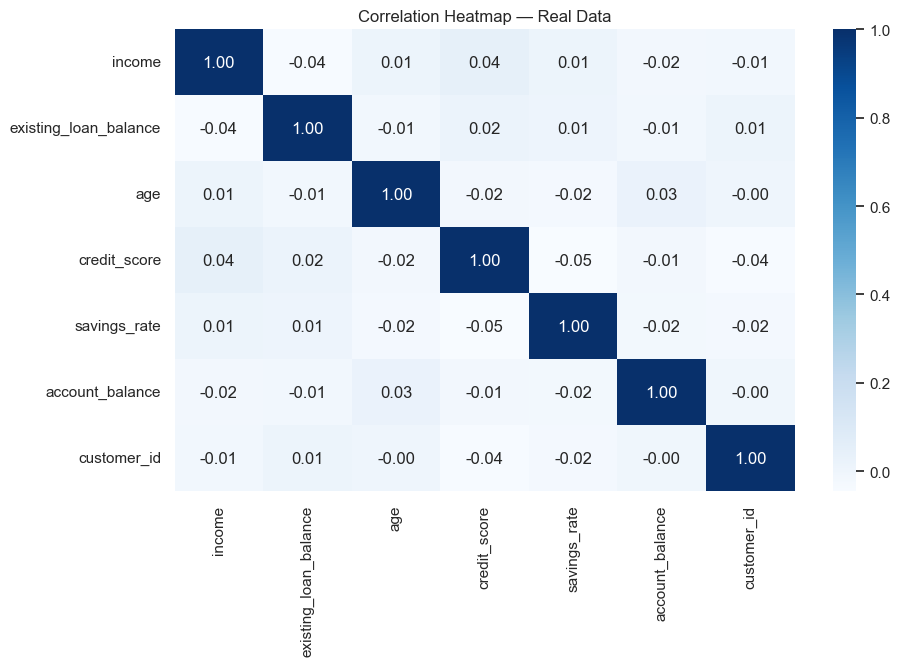

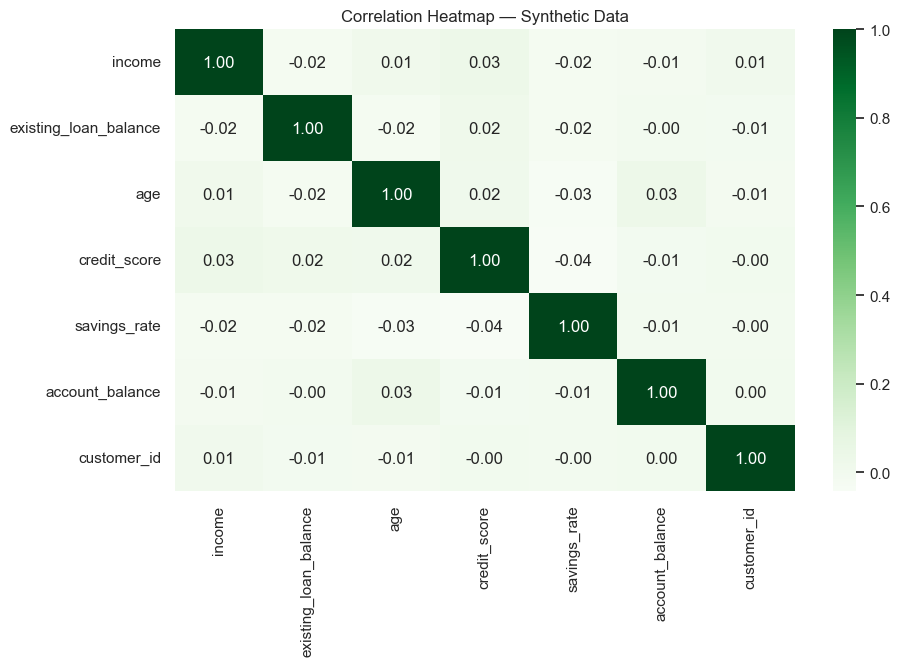

In [12]:
# Real data correlation
plt.figure(figsize=(10, 6))
sns.heatmap(real[numeric_cols].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap — Real Data")
plt.show()

# Synthetic data correlation
plt.figure(figsize=(10, 6))
sns.heatmap(synthetic[numeric_cols].corr(), annot=True, cmap="Greens", fmt=".2f")
plt.title("Correlation Heatmap — Synthetic Data")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




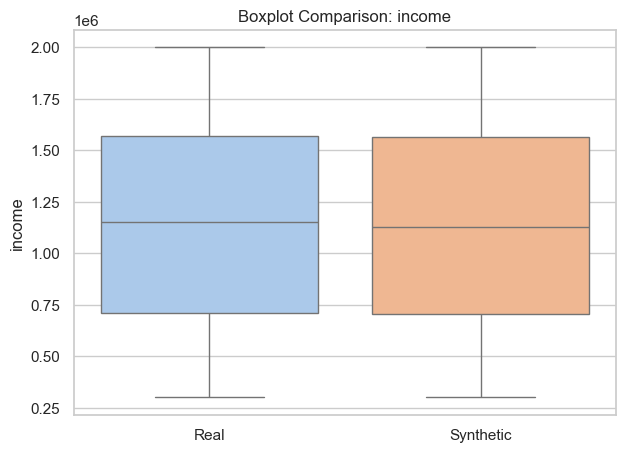

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




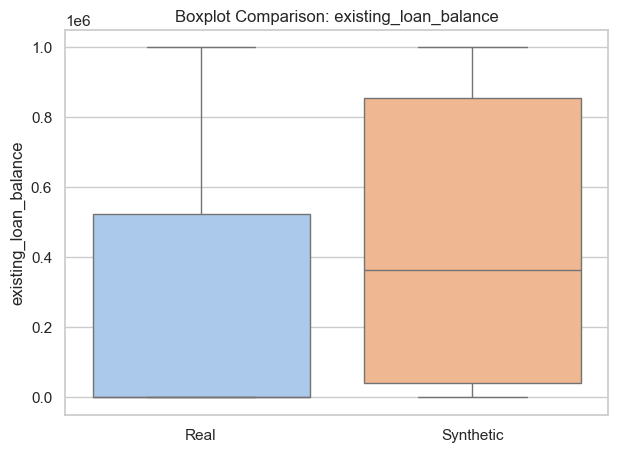

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




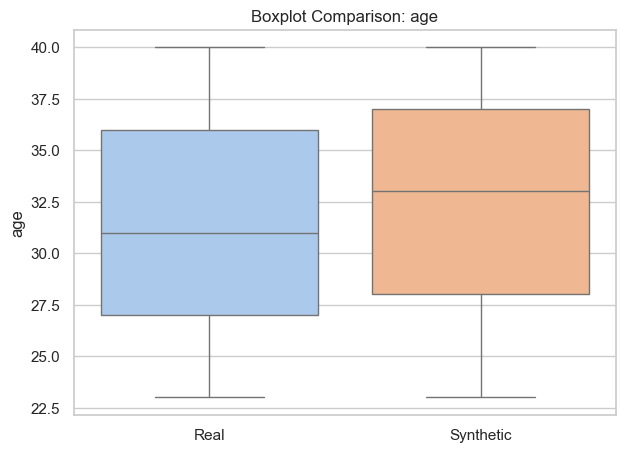

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




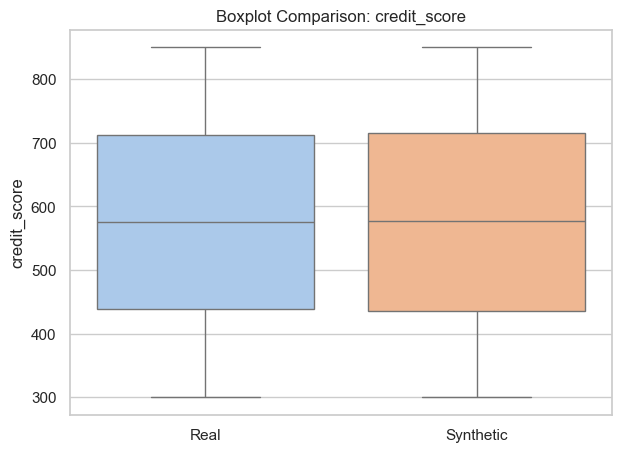

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




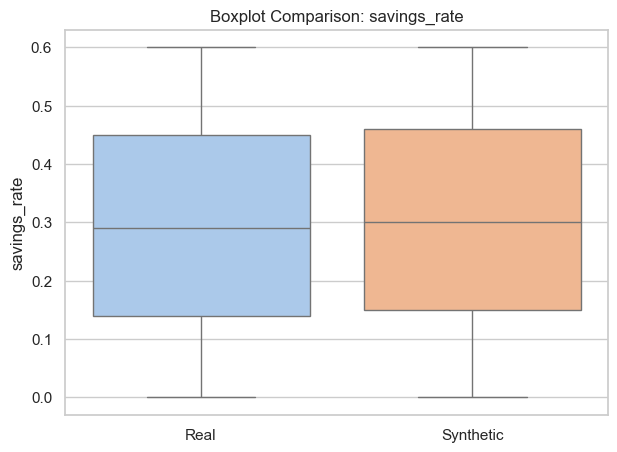

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




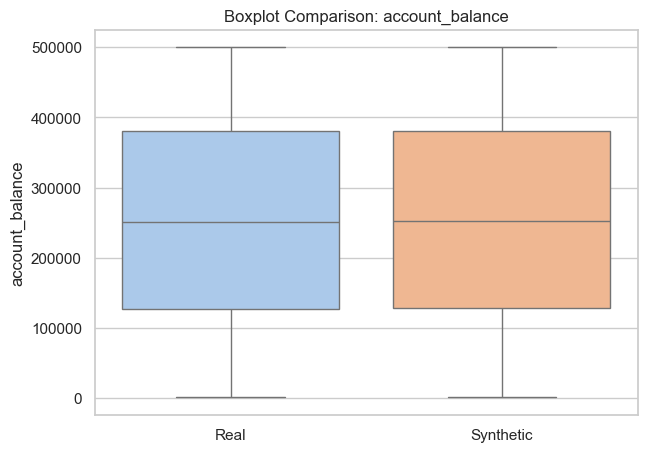

C:\Users\user\AppData\Local\Temp\ipykernel_23596\542709570.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




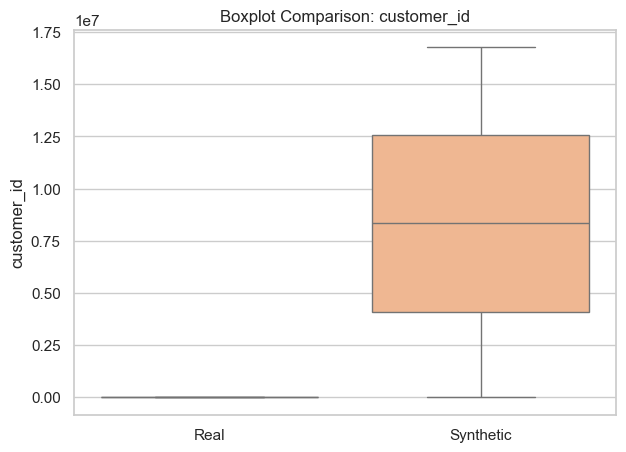

In [13]:
for col in numeric_cols:
    df_compare = pd.DataFrame({
        'value': pd.concat([real[col], synthetic[col]], axis=0),
        'type': ['Real'] * len(real[col]) + ['Synthetic'] * len(synthetic[col])
    })
    plt.figure(figsize=(7, 5))
    sns.boxplot(x='type', y='value', data=df_compare, palette="pastel")
    plt.title(f"Boxplot Comparison: {col}")
    plt.xlabel("")
    plt.ylabel(col)
    plt.show()

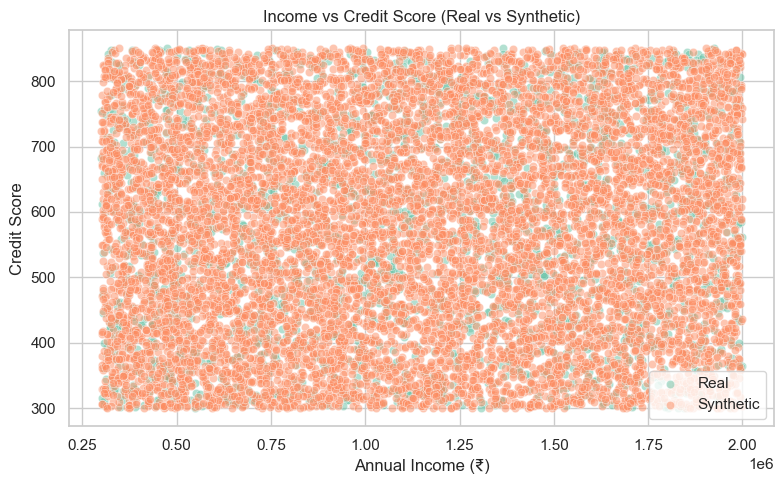

In [15]:
plt.figure()
sns.scatterplot(x='income', y='credit_score', data=real, label='Real', alpha=0.5)
sns.scatterplot(x='income', y='credit_score', data=synthetic, label='Synthetic', alpha=0.5)
plt.title("Income vs Credit Score (Real vs Synthetic)")
plt.xlabel("Annual Income (₹)")
plt.ylabel("Credit Score")
plt.legend()
plt.tight_layout()
plt.show()

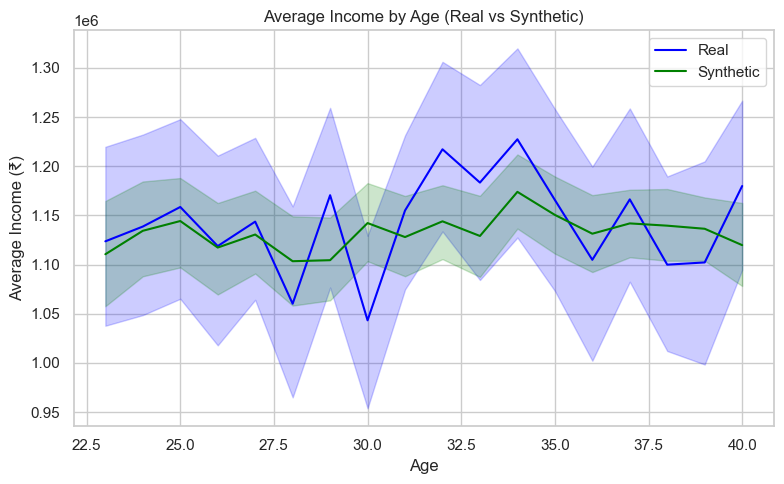

In [16]:
plt.figure()
sns.lineplot(x='age', y='income', data=real, label='Real', color='blue')
sns.lineplot(x='age', y='income', data=synthetic, label='Synthetic', color='green')
plt.title("Average Income by Age (Real vs Synthetic)")
plt.xlabel("Age")
plt.ylabel("Average Income (₹)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
output_dir = os.path.join(DOWNLOADS, "visualization_phase2")
os.makedirs(output_dir, exist_ok=True)

for col in numeric_cols:
    plt.figure()
    sns.kdeplot(real[col], label='Real', fill=True)
    sns.kdeplot(synthetic[col], label='Synthetic', fill=True)
    plt.title(f"Distribution Comparison: {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{col}_distribution.png"), dpi=300)
    plt.close()

print(f"Saved plots to: {output_dir}")


Saved plots to: C:\Users\user\Downloads\synthetic_data\visualization_phase2
